## 0) Goal

We recall that the goal in this project is to predict the kind of pollutant an industrial facility is likely to emit given its particularities.

In order to do so, we will first need to extract the information from different sources. We will then have to preprocess all this knowledge, dealing with many issues these data sets have, in order to have clean and structured data. Finally, we will train and evaluate different machine learning classification models, selecting the one that seems to perform better.

Let's get to it!

## 1) Extraction of the data

First, we install and import a few of modules we'll be using later in the script. 

In [1]:
!pip install PyMuPDF
!pip install dython

In [73]:
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import zipfile
import fitz 
import io
import os

from dython.nominal import associations
from dython.nominal import correlation_ratio
from dython.nominal import cramers_v

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


pd.set_option('display.max_columns', None) # helps visualize all the columns of the data set
pd.set_option('display.max_rows', 20)

One of the first challenges we've come accross is that the information we need to train and validate our models comes in different shapes and formats.

Indeed, the data is given in PDF, json and csv files. Python can handle json and csv files perfectly, but in the case of PDF we've had to make our own algorithms (see below).

As for the shape, the amount of characteristics about a certain industrial facility varies depending on the format, as well as the order in which it is given. Thankfully, Python can handle this issues, by selecting an ordering for all of the data sets and concatenating the information. It also puts NaN values for the variables that are not present in certain rows.

### 1.1) PDF extraction

The code below shows the methods we use to extract the information from the pdfs.

In [3]:
def get_between(s, start, end, strip=True):
  """
  Returns the substring in s between the strings start and end, which should also be substrings of s. 
  For example, get_between("123this abcwiwi", "123", "abc") returns "this". 
  strip indicates if output has to be stripped (remove spaces from the beggining and the end).
  """
  res = s[s.find(start)+len(start):s.rfind(end)]
  if not strip:
    res
  return res.strip()

def convert_unit(num):
  """
  Transforms the numerical quantities that appear wrongly in the PDF,
  since csv files interpret differently "," and ".", causing small values to be huge:
  ex:
  wrong: 18,27379291874718 --> 18E15
  right: 18,27             --> 18.27
  """
  if "," in num:
    num = num.replace(",", ".")
  num = float(num)
  while num > 30 or num < -10:
    num /= 10
  return num

def read_pdf(url):
  """
  Reads the zip file specified in the url, that should contain multiple PDF files with pollution reports,
  and returns a data frame with all the data contained in those PDF files.
  """
  rows = []
  with zipfile.ZipFile(url, "r") as zf:
    for filename in zf.namelist():
      if filename.endswith(".pdf"):
        with fitz.Document(stream=zf.read(filename)) as pdf:
          text = ""
          for page in pdf:
            text += page.get_text()
          
          row = {}
          row["countryName"] = get_between(text, "COUNTRY:", "CONTINENT:")
          row["eprtrSectorName"] = get_between(text, "eprtrSectorName:", "MainActivityCode:")
          row["EPRTRAnnexIMainActivityLabel"] = get_between(text, "eprtrSectorName:", "MainActivityCode:")
          row["FacilityInspireID"] = get_between(text, "FacilityInspireID:", "COUNTRY:")
          row["facilityName"] = get_between(text, "FACILITY NAME:", "FacilityInspireID:").split("\n")[0]
          row["City"] = get_between(text, "CITY:", "EPRTRSectorCode:")
          row["pollutant"] = get_between(text, "pollutant:", "emissions:")
          row["reportingYear"] = get_between(text, "YEAR:", "METEOROLOGICAL CONDITIONS")
          row["MONTH"] = get_between(text, "MONTH:", "YEAR:")
          row["DAY"] = get_between(text, "DAY:", "MONTH:")
          row["CONTINENT"] = get_between(text, "CONTINENT:", "CITY:")
          row["max_wind_speed"] = convert_unit(get_between(text, "max_wind_speed:", "min_wind_speed:"))
          row["avg_wind_speed"] = convert_unit(get_between(text, "avg_wind_speed:", "max_temp:"))
          row["min_wind_speed"] = convert_unit(get_between(text, "min_wind_speed:", "avg_wind_speed:"))
          row["max_temp"] = convert_unit(get_between(text, "max_temp:", "min_temp:"))
          row["avg_temp"] = convert_unit(get_between(text, "avg_temp:", "DAYS FOG:"))
          row["min_temp"] = convert_unit(get_between(text, "min_temp:", "avg_temp:"))
          row["DAY WITH FOGS"] = get_between(text, "DAYS FOG:", "REPORTER NAME:")
          row["REPORTER NAME"] = get_between(text, "REPORTER NAME:", "CITY_ID")
          row["CITY ID"] = text[text.find("CITY_ID")+len("CITY_ID"):].strip()
          row["EPRTRAnnexIMainActivityCode"] = get_between(text, "MainActivityCode:", "targetRealase:")
          row["EPRTRSectorCode"] = get_between(text, "EPRTRSectorCode:", "eprtrSectorName:")
          rows.append(row)
  pdf_df = pd.DataFrame.from_dict(rows)
  return pdf_df

### 1.2) CSV and JSON extraction

Here we use the previous functions and pandas' ones to extract and merge all the information in a single data set, train_df.

In [4]:
url_1 = "train1.csv"
url_2 = "train2.csv"
url_3 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first"
url_4 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second"
url_5 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
url_6 = "train6.zip"

train1_df = pd.read_csv(url_1, delimiter=',')
train2_df = pd.read_csv(url_2, delimiter=';') # note the separator is different from the previous one
train3_df = pd.read_json(url_3)
train4_df = pd.read_json(url_4)
train5_df = pd.read_json(url_5)
train6_df = read_pdf(url_6)

train_df = pd.concat([train1_df, train2_df, train3_df, train4_df, train5_df, train6_df], ignore_index=True)
train_df = train_df.rename(columns = {'':'unknown'})
train_df

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,DAY,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,unknown,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,20,EUROPE,15.118767,14.312541,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,21,EUROPE,19.661550,19.368166,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),2019,2,4,EUROPE,12.729453,14.701985,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),2012,8,6,EUROPE,11.856417,16.122584,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),2018,12,22,EUROPE,17.111930,20.201604,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65705,United Kingdom,Waste and wastewater management,Waste and wastewater management,UK.SEPA/200000094.Facility,"Lochhead Landfill Site, Drumfermiline",Dunfermline,NaN,Methane (CH4),2019,12,26,EUROPE,18.400000,19.900000,22.500000,9.810000,11.200000,12.800000,2,Julie Shaffer,ca2df88517d85dbac7129467fbd1effc,NaN,5(d),5
65706,United Kingdom,Waste and wastewater management,Waste and wastewater management,UK.SEPA/200000095.Facility,"Lower Melville Wood Landfill, By Ladybank","Cupar, Fife",NaN,Methane (CH4),2019,10,27,EUROPE,13.700000,14.700000,22.500000,9.600000,9.190000,12.500000,9,Brenda Holland,d784f55b1d1ae261dff896b5030ca94e,NaN,5(d),5
65707,United Kingdom,Energy sector,Energy sector,UK.SEPA/200000061.Facility,Fife Ethylene Plant,Cowdenbeath,NaN,Carbon dioxide (CO2),2019,4,12,EUROPE,15.200000,14.600000,20.600000,9.610000,8.690000,13.300000,19,Shawn Graham,3c563ab0d76fc84128574b5da82f769a,NaN,1(c),1
65708,United Kingdom,Waste and wastewater management,Waste and wastewater management,UK.SEPA/200000115.Facility,"Avondale Landfill Site, Polmont",Polmont,NaN,Nitrogen oxides (NOX),2019,11,13,EUROPE,17.300000,16.500000,18.700000,9.370000,-2.000000,11.200000,7,Hunter Davidson,941b15d27183b05e8e58e0fbc509e963,NaN,5(d),5


## 2) Analysis and preprocessing of the data set

### 2.1) Unordered values

Carefully analysing some of the variables in the data set, we noticed that maximum, minimum and average values both for wind and temperature were not consistent. Indeed, in some cases, the maximum was smaller than the average one for example. It looks like the values have been permuted, so the most logical thing to do seems to be assigning, for each row, the minimum, average and maximum from smallest to biggest value. That's exactly what we do in the following code:

In [5]:
#sorting the numerical metrics
for ind in train_df.index:
  wind_speed = np.array([train_df['min_wind_speed'][ind], train_df['avg_wind_speed'][ind], train_df['max_wind_speed'][ind]])
  sorted_ws_values = np.sort(wind_speed)
  train_df.loc[ind, 'min_wind_speed'] = sorted_ws_values[0]
  train_df.loc[ind, 'avg_wind_speed'] = sorted_ws_values[1]
  train_df.loc[ind, 'max_wind_speed'] = sorted_ws_values[2]

  temp = np.array([train_df['min_temp'][ind], train_df['avg_temp'][ind], train_df['max_temp'][ind]])
  sorted_temp_values = np.sort(temp)
  train_df.loc[ind, 'min_temp'] = sorted_temp_values[0]
  train_df.loc[ind, 'avg_temp'] = sorted_temp_values[1]
  train_df.loc[ind, 'max_temp'] = sorted_temp_values[2]

#saving the data to a json file so we don't have to reorder
train_df.to_json('sorted_tr.json')

We save the result in case you want to work with it later.

In [30]:
train_df = pd.read_json("sorted_tr.json")
train_df

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,DAY,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,unknown,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,20,EUROPE,21.419106,15.118767,14.312541,9.688206,4.924169,2.864895,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,None,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,21,EUROPE,21.756389,19.661550,19.368166,12.023521,7.864403,5.462839,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,None,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),2019,2,4,EUROPE,17.103930,14.701985,12.729453,8.632193,4.233438,1.511201,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,None,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),2012,8,6,EUROPE,17.537184,16.122584,11.856417,15.179215,10.970301,10.298348,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,None,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),2018,12,22,EUROPE,21.536012,20.201604,17.111930,16.039004,11.772039,11.344078,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65705,United Kingdom,Waste and wastewater management,Waste and wastewater management,UK.SEPA/200000094.Facility,"Lochhead Landfill Site, Drumfermiline",Dunfermline,None,Methane (CH4),2019,12,26,EUROPE,22.500000,19.900000,18.400000,12.800000,11.200000,9.810000,2,Julie Shaffer,ca2df88517d85dbac7129467fbd1effc,NaN,5(d),5.0
65706,United Kingdom,Waste and wastewater management,Waste and wastewater management,UK.SEPA/200000095.Facility,"Lower Melville Wood Landfill, By Ladybank","Cupar, Fife",None,Methane (CH4),2019,10,27,EUROPE,22.500000,14.700000,13.700000,12.500000,9.600000,9.190000,9,Brenda Holland,d784f55b1d1ae261dff896b5030ca94e,NaN,5(d),5.0
65707,United Kingdom,Energy sector,Energy sector,UK.SEPA/200000061.Facility,Fife Ethylene Plant,Cowdenbeath,None,Carbon dioxide (CO2),2019,4,12,EUROPE,20.600000,15.200000,14.600000,13.300000,9.610000,8.690000,19,Shawn Graham,3c563ab0d76fc84128574b5da82f769a,NaN,1(c),1.0
65708,United Kingdom,Waste and wastewater management,Waste and wastewater management,UK.SEPA/200000115.Facility,"Avondale Landfill Site, Polmont",Polmont,None,Nitrogen oxides (NOX),2019,11,13,EUROPE,18.700000,17.300000,16.500000,11.200000,9.370000,-2.000000,7,Hunter Davidson,941b15d27183b05e8e58e0fbc509e963,NaN,5(d),5.0


### 2.1) Dropping off some redundant, useless or too specific information

Moreover, we believe that many of the variables contained in the data set are not useful for predicing the pollutant.

Let's take a look at some of the statistics of the data set:


In [31]:
train_df.describe(include="all")

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,DAY,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,unknown,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
count,65710,65710,65710,65710,65710,65710,65628,65710,65710.000000,65710.000000,65710.000000,65710,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710,65710,28501.000000,28583,28583.000000
unique,32,9,76,7187,7934,5138,1,3,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45065,5138,NaN,70,NaN
top,United Kingdom,Energy sector,Thermal power stations and other combustion in...,https://data.ied_registry.omgeving.vlaanderen....,Enel Produzione S.p.A.,--,AIR,Nitrogen oxides (NOX),NaN,NaN,NaN,EUROPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Michael Brown,cfab1ba8c67c7c838db98d666f02a132,NaN,1(c),NaN
freq,9098,24588,21527,42,234,1975,65628,26002,NaN,NaN,NaN,65710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,1975,NaN,9396,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.942611,6.489621,14.516025,NaN,22.520943,18.086172,15.444590,13.445199,10.576324,9.329597,2.241318,NaN,NaN,40836.986457,NaN,3.169541
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.857197,3.450712,8.097139,NaN,3.059952,2.320061,3.000038,5.215627,5.091657,5.181750,3.789124,NaN,NaN,23584.386942,NaN,2.041248
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,1.000000,1.000000,NaN,15.032589,14.000000,8.011958,0.894827,-0.199176,-3.141464,0.000000,NaN,NaN,0.000000,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,3.000000,8.000000,NaN,20.346104,16.079339,13.324152,9.897878,7.287003,5.806896,0.000000,NaN,NaN,20308.000000,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,7.000000,14.000000,NaN,22.540172,18.095491,15.437275,13.693176,10.827833,9.566563,1.000000,NaN,NaN,40768.000000,NaN,3.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,9.000000,22.000000,NaN,24.715216,20.089890,17.622064,17.270788,14.322587,13.133990,2.000000,NaN,NaN,61272.000000,NaN,5.000000


The first thing we notice is that 'targetRelease' and 'CONTINENT' are always equal to 'Air' and 'Europe' respectively, so they don't give any information to the data set.

On the other hand, some variables globally explain the same thing as other ones. It is the case of 'EPRTRSectorCode' and 'eprtrSectorName', as well as 'FacilityInspireID' and 'facilityName'.
We decide to drop the first one in the two cases.
The same happens with 'EPRTRAnnexIMainActivityCode' and 'EPRTRAnnexIMainActivityLabel'. We delete the 1st one too.

Moreover, we consider the 'REPORTER NAME' as being unuseful for the final goal, considering that the result for a given industrial facility will be the same no matter the analyst in charge of the task (no corruption involved a priori).

Finally, we believe that the day won't give us more information than the one we get from other temporal variables such as the year or the month, which do contain information about stationality in climate but also in the work involved in the factory (production in a facility might vary from time to time, in different years or months).

In [32]:
train_df = train_df.drop(['targetRelease', 'CONTINENT', 'EPRTRSectorCode', 'FacilityInspireID', 'EPRTRAnnexIMainActivityCode', 'REPORTER NAME', 'DAY'], axis = 1)

The resulting dataframe is:

In [33]:
train_df

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,facilityName,City,pollutant,reportingYear,MONTH,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,CITY ID,unknown
0,Germany,Mineral industry,Installations for the production of cement cli...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,Carbon dioxide (CO2),2015,10,21.419106,15.118767,14.312541,9.688206,4.924169,2.864895,2,7cdb5e74adcb2ffaa21c1b61395a984f,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,Nitrogen oxides (NOX),2018,9,21.756389,19.661550,19.368166,12.023521,7.864403,5.462839,1,cd1dbabbdba230b828c657a9b19a8963,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,Methane (CH4),2019,2,17.103930,14.701985,12.729453,8.632193,4.233438,1.511201,2,5011e3fa1436d15b34f1287f312fbada,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,Elektrárny Prunéřov,Kadaň,Nitrogen oxides (NOX),2012,8,17.537184,16.122584,11.856417,15.179215,10.970301,10.298348,0,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,Methane (CH4),2018,12,21.536012,20.201604,17.111930,16.039004,11.772039,11.344078,2,471fe554e1c62d1b01cc8e4e5076c61a,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65705,United Kingdom,Waste and wastewater management,Waste and wastewater management,"Lochhead Landfill Site, Drumfermiline",Dunfermline,Methane (CH4),2019,12,22.500000,19.900000,18.400000,12.800000,11.200000,9.810000,2,ca2df88517d85dbac7129467fbd1effc,NaN
65706,United Kingdom,Waste and wastewater management,Waste and wastewater management,"Lower Melville Wood Landfill, By Ladybank","Cupar, Fife",Methane (CH4),2019,10,22.500000,14.700000,13.700000,12.500000,9.600000,9.190000,9,d784f55b1d1ae261dff896b5030ca94e,NaN
65707,United Kingdom,Energy sector,Energy sector,Fife Ethylene Plant,Cowdenbeath,Carbon dioxide (CO2),2019,4,20.600000,15.200000,14.600000,13.300000,9.610000,8.690000,19,3c563ab0d76fc84128574b5da82f769a,NaN
65708,United Kingdom,Waste and wastewater management,Waste and wastewater management,"Avondale Landfill Site, Polmont",Polmont,Nitrogen oxides (NOX),2019,11,18.700000,17.300000,16.500000,11.200000,9.370000,-2.000000,7,941b15d27183b05e8e58e0fbc509e963,NaN


Let's do another analysis to see if we need to drop more variables. This time, using correlation between them.

In [34]:
output = associations(train_df)
correlation = output['corr']

<AxesSubplot:>

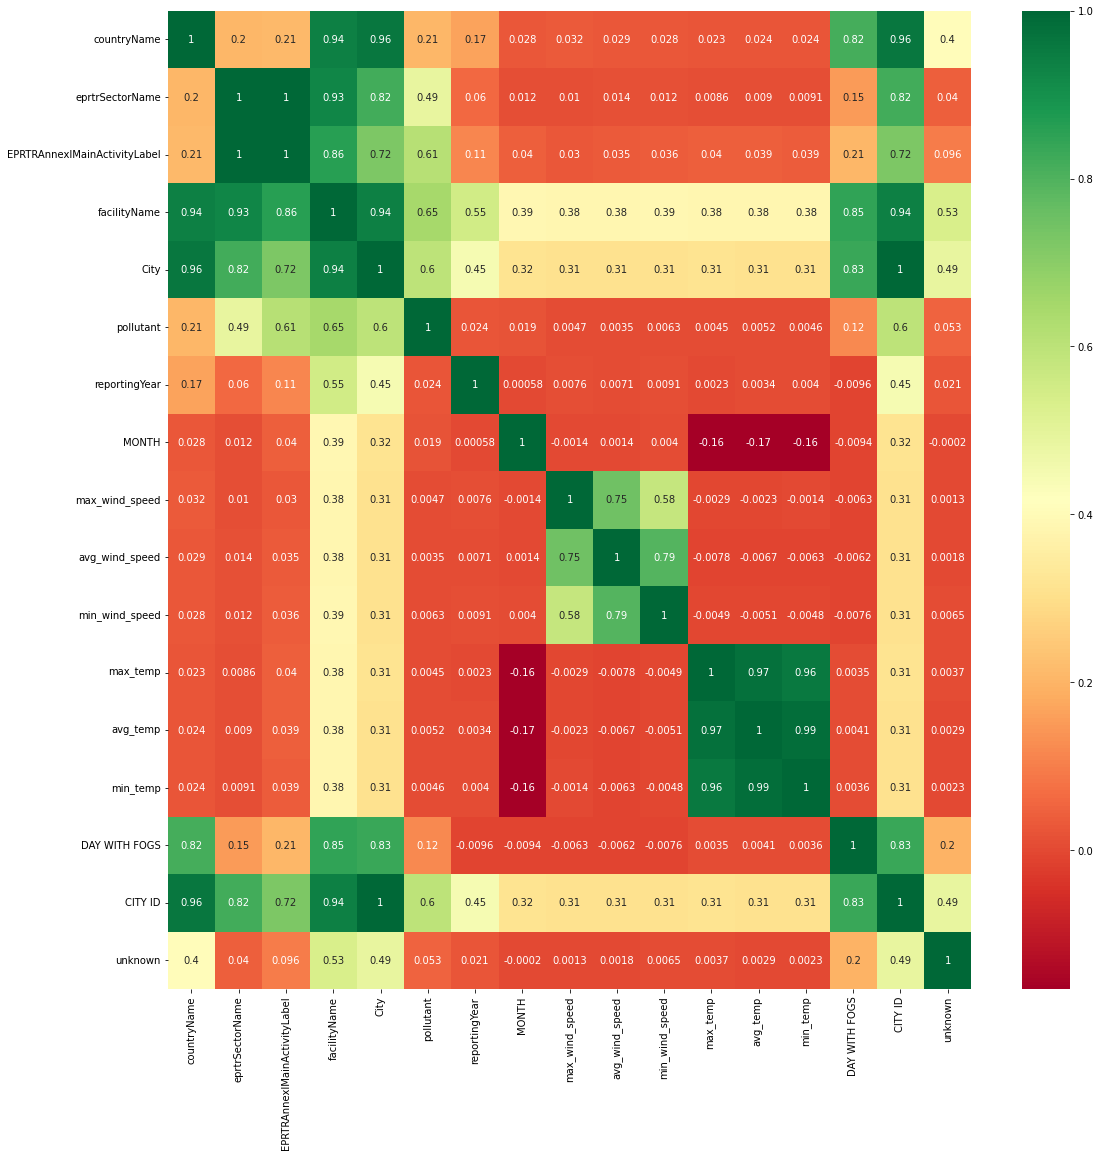

In [35]:
plt.figure(figsize=(18,18))
sns.heatmap(correlation, cmap="RdYlGn", annot=True)

In [36]:
train_df.describe(include="all")

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,facilityName,City,pollutant,reportingYear,MONTH,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,CITY ID,unknown
count,65710,65710,65710,65710,65710,65710,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710.000000,65710,28501.000000
unique,32,9,76,7934,5138,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5138,NaN
top,United Kingdom,Energy sector,Thermal power stations and other combustion in...,Enel Produzione S.p.A.,--,Nitrogen oxides (NOX),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cfab1ba8c67c7c838db98d666f02a132,NaN
freq,9098,24588,21527,234,1975,26002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2012.942611,6.489621,22.520943,18.086172,15.444590,13.445199,10.576324,9.329597,2.241318,NaN,40836.986457
std,NaN,NaN,NaN,NaN,NaN,NaN,3.857197,3.450712,3.059952,2.320061,3.000038,5.215627,5.091657,5.181750,3.789124,NaN,23584.386942
min,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,1.000000,15.032589,14.000000,8.011958,0.894827,-0.199176,-3.141464,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,3.000000,20.346104,16.079339,13.324152,9.897878,7.287003,5.806896,0.000000,NaN,20308.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,7.000000,22.540172,18.095491,15.437275,13.693176,10.827833,9.566563,1.000000,NaN,40768.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,9.000000,24.715216,20.089890,17.622064,17.270788,14.322587,13.133990,2.000000,NaN,61272.000000


First of all, 'EPRTRAnnexIMainActivityLabel' and 'eprtrSectorName' have a correlation of 1. We therefore consider dropping off the second one, particularly because we believe having more detailed information about the activity performed in the facility will have more relation to the polutant emited. 
Following with this case, one analysis we've also performed is based on trying out different models using some of the variables in order to try and see which combination gave a better result. In this case, we also observe that selecting 'EPRTRAnnexIMainActivityLabel' performs better than taking 'eprtrSectorName'.

Aside from that, we observe that 'CITY_ID' and 'facility_name' are greatly correlated to the 'country_name'. Contrary to the previous case, we believe that taking the variable with less categories is enough, because it also contains the information of the more detailed ones (otherwise, its correlation wouldn't be as strong) and we simplify the model. We decide to only keep 'country_name' and drop the other two.

Moreover, we consider the variable 'City' have way too many values to be used in one of our models, so we decide to take it out as well.

Finally, information in minimum, average and maximum values both for wind and temperature is somewhat redundant. Keeping the average seems to be enough. However, we also consider adding a new variable in both cases which would contain the range of possible values: the difference between the maximum and the minimum. We therefore drop these last two in favor of the new one.

In [37]:
train_df["range_wind_speed"] = train_df["max_wind_speed"] - train_df["min_wind_speed"]
train_df["range_temp"] = train_df["max_temp"] - train_df["min_temp"]

train_df = train_df.drop(['countryName', 'eprtrSectorName', 'CITY ID', 'facilityName', 'City',
                          "max_wind_speed", "min_wind_speed", "max_temp", "min_temp"], axis = 1)
# train_df = train_df.drop(['EPRTRAnnexIMainActivityLabel', 'CITY ID', 'facilityName', 'City',
#                           "max_wind_speed", "min_wind_speed", "max_temp", "min_temp"], axis = 1)

In [38]:
train_df.to_json("pre1_tr.json")

In [39]:
train_df = pd.read_json("pre1_tr.json")

### 2.2) Preprocessing of categorical variables

We convert the 'pollutant' variable to the values stated in the Data Science SE.

In [40]:
train_df["pollutant"].unique()

array(['Carbon dioxide (CO2)', 'Nitrogen oxides (NOX)', 'Methane (CH4)'],
      dtype=object)

In [41]:
train_df["pollutant"] = train_df["pollutant"].map({"Nitrogen oxides (NOX)": 0, "Carbon dioxide (CO2)": 1, "Methane (CH4)": 2})

In [42]:
train_df["pollutant"].unique()

array([1, 0, 2])

In the case of the variable 'MONTH', we don't like the typical ordering one would initially think, considering the values [1,12] for ['January', 'December'], since that would imply January and December being very different from each other.

We therefore decide to use another encoding which considers the overall temperature in a specific month, ranging from 0 (cold), to 5 (hot). Remember we are considering facilities located in Europe, not in countries lower than the equator.

In [43]:
train_df["MONTH"] = train_df["MONTH"].map({1:0, 2:0, 3:1 , 4:2, 5:3, 6:4, 7:5, 8:5, 9:3, 10:2, 11:1, 12:0})

We finally use a one hot encoding for 'EPRTRAnnexIMainActivityLabel'.

In [44]:
# train_df = pd.get_dummies(train_df, columns=['eprtrSectorName','countryName'])
train_df = pd.get_dummies(train_df, columns=['EPRTRAnnexIMainActivityLabel'])
train_df

,pollutant,reportingYear,MONTH,avg_wind_speed,avg_temp,DAY WITH FOGS,unknown,range_wind_speed,range_temp,EPRTRAnnexIMainActivityLabel_Chemical industry,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Acids, such as chromic acid, hydrofluoric acid, phosphoric acid, nitric acid, hydrochloric acid, sulphuric acid, oleum, sulphurous acids","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Bases, such as ammonium hydroxide, potassium hydroxide, sodium hydroxide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Gases, such as ammonia, chlorine or hydrogen chloride, fluorine or hydrogen fluoride, carbon oxides, sulphur compounds, nitrogen oxides, hydrogen, sulphur dioxide, carbonyl chloride","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Non-metals, metal oxides or other inorganic compounds such as calcium carbide, silicon, silicon carbide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Salts, such as ammonium chloride, potassium chlorate, potassium carbonate, sodium carbonate, perborate, silver nitrate","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Basic plastic materials (polymers, synthetic fibres and cellulose-based fibres)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Dyes and pigments,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Halogenic hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Nitrogenous hydrocarbons such as amines, amides, nitrous compounds, nitro compounds or nitrate compounds, nitriles, cyanates, isocyanates",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Organometallic compounds,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Oxygen-containing hydrocarbons such as alcohols, aldehydes, ketones, carboxylic acids, esters, acetates, ethers, peroxides, epoxy resins",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Phosphorus-containing hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Simple hydrocarbons (linear or cyclic, saturated or unsaturated, aliphatic or aromatic)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Sulphurous hydrocarbons,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Surface-active agents and surfactants,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Synthetic rubbers,EPRTRAnnexIMainActivityLabel_Chemical installations for t

### 2.3) Preprocessing of numerical variables

#### 2.3.1) KNN imputation for NaN values:

Let's take a look at which variables have NaN values:

In [45]:
train_df.isna().sum()

pollutant                                                                                                                                                                                                                                                                           0
reportingYear                                                                                                                                                                                                                                                                       0
MONTH                                                                                                                                                                                                                                                                               0
avg_wind_speed                                                                                                                                                        

*As we can see, only 'unknown', a variable whose values only appeared in the json files, has in fact NaN values.*
*The KNN imputation will therefore not affect the rest of the information.*

One thing we've noticed is that the test doesn't contain the variable unknown, so we won't use to train the models.
We will therefore drop this column, and since there will not be any NaN value, we will not perform a KNN imputation.

In [46]:
# imputer = KNNImputer()
# knn_imputed = imputer.fit_transform(train_df)
# train_df = pd.DataFrame(knn_imputed, columns=train_df.columns)
# train_df.to_json("pre2_tr.json")

In [47]:
train_df = train_df.drop(["unknown"], axis=1)

#### 2.3.2) Scaling and Yeo-Johnson transform

Scaling and performing a Yeo-Johnson transform for the numerical variables helps the algorithm, both for its efficiency and its performance.


Note that we do a previous scaling of 'reportingYear' because otherwise the results were too litlle.

In [48]:
train_df["reportingYear"] = df["reportingYear"].astype(int) - 2007

In [50]:
pt = PowerTransformer()
train_df[["reportingYear",	"MONTH",	"avg_wind_speed",	"avg_temp",	"DAY WITH FOGS", "range_wind_speed", "range_temp"]] = \
 pt.fit_transform(train_df[["reportingYear",	"MONTH",	"avg_wind_speed",	"avg_temp",	"DAY WITH FOGS", "range_wind_speed", "range_temp"]])
train_df

,pollutant,reportingYear,MONTH,avg_wind_speed,avg_temp,DAY WITH FOGS,range_wind_speed,range_temp,EPRTRAnnexIMainActivityLabel_Chemical industry,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Acids, such as chromic acid, hydrofluoric acid, phosphoric acid, nitric acid, hydrochloric acid, sulphuric acid, oleum, sulphurous acids","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Bases, such as ammonium hydroxide, potassium hydroxide, sodium hydroxide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Gases, such as ammonia, chlorine or hydrogen chloride, fluorine or hydrogen fluoride, carbon oxides, sulphur compounds, nitrogen oxides, hydrogen, sulphur dioxide, carbonyl chloride","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Non-metals, metal oxides or other inorganic compounds such as calcium carbide, silicon, silicon carbide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Salts, such as ammonium chloride, potassium chlorate, potassium carbonate, sodium carbonate, perborate, silver nitrate","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Basic plastic materials (polymers, synthetic fibres and cellulose-based fibres)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Dyes and pigments,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Halogenic hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Nitrogenous hydrocarbons such as amines, amides, nitrous compounds, nitro compounds or nitrate compounds, nitriles, cyanates, isocyanates",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Organometallic compounds,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Oxygen-containing hydrocarbons such as alcohols, aldehydes, ketones, carboxylic acids, esters, acetates, ethers, peroxides, epoxy resins",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Phosphorus-containing hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Simple hydrocarbons (linear or cyclic, saturated or unsaturated, aliphatic or aromatic)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Sulphurous hydrocarbons,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Surface-active agents and surfactants,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Synthetic rubbers,EPRTRAnnexIMainActivityLabel_Chemical installations for the produ

## 3) Models

#### 3.1) Model training and assessment

The first thing we do is separate the data into two subsets: one will serve for training the model, and the other one to assess its performance. We are basically doing a one-shot cross validation. We won't perform a bigger cross one because of time constraints.

In [51]:
X = train_df.loc[:, train_df.columns != 'pollutant']
y = train_df['pollutant']

In [52]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.3)
print(X.shape, X_val.shape)

(45997, 83) (19713, 83)


In [53]:
def model_assess(model):
    model.fit(X, y)
    preds = model.predict(X_val)
    print(str(model))
    print('Accuracy:', round(accuracy_score(y_val, preds), 5))
    print('F1 score (macro):', round(f1_score(y_val, preds, average="macro"), 5))

In [54]:
model_assess(SVC())

SVC()
Accuracy: 0.61503
F1 score (macro): 0.64108


In [55]:
model_assess(RandomForestClassifier())

RandomForestClassifier()
Accuracy: 0.66672
F1 score (macro): 0.69156


In [56]:
model_assess(RandomForestClassifier(n_estimators=1000))

RandomForestClassifier(n_estimators=1000)
Accuracy: 0.66859
F1 score (macro): 0.69368


In [57]:
model_assess(RandomForestClassifier(n_estimators=1000, max_depth=10))

RandomForestClassifier(max_depth=10, n_estimators=1000)
Accuracy: 0.61503
F1 score (macro): 0.59553


In [58]:
model_assess(GradientBoostingClassifier())

GradientBoostingClassifier()
Accuracy: 0.61259
F1 score (macro): 0.61175


In [59]:
model_assess(MLPClassifier(max_iter=1000))

MLPClassifier(max_iter=1000)
Accuracy: 0.61036
F1 score (macro): 0.64095


In [60]:
model_assess(LogisticRegression(max_iter=10000))

LogisticRegression(max_iter=10000)
Accuracy: 0.61731
F1 score (macro): 0.63515


In [61]:
model_assess(AdaBoostClassifier())

AdaBoostClassifier()
Accuracy: 0.61218
F1 score (macro): 0.62099


In [63]:
model_assess(DecisionTreeClassifier())

DecisionTreeClassifier()
Accuracy: 0.63664
F1 score (macro): 0.65536


# FINAL

In [87]:
def process_dataframe(df):
  for ind in df.index:
    wind_speed = np.array([df['min_wind_speed'][ind], df['avg_wind_speed'][ind], df['max_wind_speed'][ind]])
    sorted_ws_values = np.sort(wind_speed)
    df.loc[ind, 'min_wind_speed'] = sorted_ws_values[0]
    df.loc[ind, 'avg_wind_speed'] = sorted_ws_values[1]
    df.loc[ind, 'max_wind_speed'] = sorted_ws_values[2]

    temp = np.array([df['min_temp'][ind], df['avg_temp'][ind], df['max_temp'][ind]])
    sorted_temp_values = np.sort(temp)
    df.loc[ind, 'min_temp'] = sorted_temp_values[0]
    df.loc[ind, 'avg_temp'] = sorted_temp_values[1]
    df.loc[ind, 'max_temp'] = sorted_temp_values[2]

  df["range_wind_speed"] = df["max_wind_speed"] - df["min_wind_speed"]
  df["range_temp"] = df["max_temp"] - df["min_temp"]

  df = df.drop(['targetRelease', 'CONTINENT', 'EPRTRSectorCode', 'FacilityInspireID',
                'EPRTRAnnexIMainActivityCode', 'REPORTER NAME', 'DAY',
                'countryName', 'eprtrSectorName', 'CITY ID', 'facilityName', 'City',
                "max_wind_speed", "min_wind_speed", "max_temp", "min_temp"], axis=1)

  if "pollutant" in df.columns:
    df["pollutant"] = df["pollutant"].map({"Nitrogen oxides (NOX)": 0, "Carbon dioxide (CO2)": 1, "Methane (CH4)": 2})

  df["MONTH"] = df["MONTH"].astype(int).map({1:0, 2:0, 3:1 , 4:2, 5:3, 6:4, 7:5, 8:5, 9:3, 10:2, 11:1, 12:0})

  df = pd.get_dummies(df, columns=['EPRTRAnnexIMainActivityLabel'])

  df["reportingYear"] = df["reportingYear"].astype(int) - 2007

  pt = PowerTransformer()
  df[["reportingYear",	"MONTH",	"avg_wind_speed",	"avg_temp",	"DAY WITH FOGS", "range_wind_speed", "range_temp"]] = \
  pt.fit_transform(df[["reportingYear",	"MONTH",	"avg_wind_speed",	"avg_temp",	"DAY WITH FOGS", "range_wind_speed", "range_temp"]])
  
  return df

In [90]:
tr_df_filename = "final_training_df.json"
if not os.path.isfile(tr_df_filename):
  tr_url_1 = "train1.csv"
  tr_url_2 = "train2.csv"
  tr_url_3 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first"
  tr_url_4 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second"
  tr_url_5 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
  tr_url_6 = "train6.zip"

  train1_df = pd.read_csv(tr_url_1, delimiter=',')
  train2_df = pd.read_csv(tr_url_2, delimiter=';') # note the separator is different from the previous one
  train3_df = pd.read_json(tr_url_3)
  train4_df = pd.read_json(tr_url_4)
  train5_df = pd.read_json(tr_url_5)
  train6_df = read_pdf(tr_url_6)

  final_train_df = pd.concat([train1_df, train2_df, train3_df, train4_df, train5_df, train6_df], ignore_index=True)
  final_train_df = final_train_df.drop([""], axis=1)

  final_train_df = process_dataframe(final_train_df)
  final_train_df.to_json(tr_df_filename)
else:
  final_train_df = pd.read_json(tr_df_filename)

final_train_df

,pollutant,reportingYear,MONTH,avg_wind_speed,avg_temp,DAY WITH FOGS,range_wind_speed,range_temp,EPRTRAnnexIMainActivityLabel_Chemical industry,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Acids, such as chromic acid, hydrofluoric acid, phosphoric acid, nitric acid, hydrochloric acid, sulphuric acid, oleum, sulphurous acids","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Bases, such as ammonium hydroxide, potassium hydroxide, sodium hydroxide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Gases, such as ammonia, chlorine or hydrogen chloride, fluorine or hydrogen fluoride, carbon oxides, sulphur compounds, nitrogen oxides, hydrogen, sulphur dioxide, carbonyl chloride","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Non-metals, metal oxides or other inorganic compounds such as calcium carbide, silicon, silicon carbide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Salts, such as ammonium chloride, potassium chlorate, potassium carbonate, sodium carbonate, perborate, silver nitrate","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Basic plastic materials (polymers, synthetic fibres and cellulose-based fibres)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Dyes and pigments,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Halogenic hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Nitrogenous hydrocarbons such as amines, amides, nitrous compounds, nitro compounds or nitrate compounds, nitriles, cyanates, isocyanates",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Organometallic compounds,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Oxygen-containing hydrocarbons such as alcohols, aldehydes, ketones, carboxylic acids, esters, acetates, ethers, peroxides, epoxy resins",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Phosphorus-containing hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Simple hydrocarbons (linear or cyclic, saturated or unsaturated, aliphatic or aromatic)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Sulphurous hydrocarbons,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Surface-active agents and surfactants,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Synthetic rubbers,EPRTRAnnexIMainActivityLabel_Chemical installations for the produ

In [111]:
te_df_filename = "final_test_df.json"
if not os.path.isfile(te_df_filename):
  te_url = "test_x.csv"

  test_df = pd.read_csv(te_url)
  test_df = test_df.drop(["test_index"], axis=1) # info already in the data frame index

  test_df = process_dataframe(test_df)
  test_df = test_df.reindex(columns=final_train_df.columns | test_df.columns).fillna(0)
  test_df = test_df.drop(["pollutant"], axis=1)
  test_df.to_json(te_df_filename)
else:
  test_df = pd.read_json(te_df_filename)

test_df

,DAY WITH FOGS,EPRTRAnnexIMainActivityLabel_Chemical industry,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Acids, such as chromic acid, hydrofluoric acid, phosphoric acid, nitric acid, hydrochloric acid, sulphuric acid, oleum, sulphurous acids","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Bases, such as ammonium hydroxide, potassium hydroxide, sodium hydroxide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Gases, such as ammonia, chlorine or hydrogen chloride, fluorine or hydrogen fluoride, carbon oxides, sulphur compounds, nitrogen oxides, hydrogen, sulphur dioxide, carbonyl chloride","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Non-metals, metal oxides or other inorganic compounds such as calcium carbide, silicon, silicon carbide","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic inorganic chemicals: Salts, such as ammonium chloride, potassium chlorate, potassium carbonate, sodium carbonate, perborate, silver nitrate","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.","EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Basic plastic materials (polymers, synthetic fibres and cellulose-based fibres)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Dyes and pigments,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Halogenic hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Nitrogenous hydrocarbons such as amines, amides, nitrous compounds, nitro compounds or nitrate compounds, nitriles, cyanates, isocyanates",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Organometallic compounds,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Oxygen-containing hydrocarbons such as alcohols, aldehydes, ketones, carboxylic acids, esters, acetates, ethers, peroxides, epoxy resins",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Phosphorus-containing hydrocarbons,"EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Simple hydrocarbons (linear or cyclic, saturated or unsaturated, aliphatic or aromatic)",EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Sulphurous hydrocarbons,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Surface-active agents and surfactants,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic organic chemicals: Synthetic rubbers,EPRTRAnnexIMainActivityLabel_Chemical installations for the production on an industrial scale of basic plant health products and of biocides,"EPRTR

In [93]:
def train_final_model(train_df):
  X = train_df.loc[:, train_df.columns != 'pollutant']
  y = train_df['pollutant']
  model = RandomForestClassifier(n_estimators=1000)
  model.fit(X, y)
  return model

trained_model = train_final_model(final_train_df)

In [114]:
def predict(trained_model, test_df, save=True):
  predictions = trained_model.predict(test_df)
  pred_df = pd.DataFrame({"test_index": test_df.index, "pollutant": predictions})
  if save:
    pred_df.to_csv("predictions.csv")
    pred_df.to_json("predictions.json")
  return pred_df

predict(trained_model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)



,test_index,pollutant
0,0,0
1,1,2
2,2,2
3,3,1
4,4,0
...,...,...
24475,24475,0
24476,24476,2
24477,24477,2
24478,24478,2
